# CPS Labor Force Nonparticipation by Reason

Brian Dew, @bd_econ

Replaces CPS_PrimeLF_Contrib.ipynb

March 19, 2019

Replication using python of a very clever chart by Ernie Tedeschi (@ernietedeschi).

[Definitions](https://www.frbatlanta.org/chcs/human-capital-currents/2015/0612-measuring-labor-market-status-using-basic-data.aspx) of labor market status come from the FRB of Atlanta.

In [1]:
# Import preliminaries
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

import os

os.chdir('/home/brian/Documents/CPS/data/clean/')

In [2]:
# Age and sex demographics in March 2001
filter_cols = ['AGE', 'FEMALE', 'NILFREASON', 'BASICWGT', 'MONTH']
df = (pd.read_feather('cps2001.ft', columns=filter_cols)
        .query('MONTH == 3 and 25 <= AGE <= 54'))

# Create dictionary with sex and age distribution in March 2001
dem_2001 = {}
for sex in [0, 1]:
    dfs = df[df['FEMALE'] == sex]
    age_dict = (dfs.groupby('AGE').BASICWGT.sum()
                / dfs.BASICWGT.sum()).to_dict()
    for age in age_dict.keys():
        dem_2001[(sex, age)] = age_dict[age]

In [3]:
results = pd.DataFrame()

for year in range(2000, 2020):
    annual_data = (pd.read_feather(f'cps{year}.ft', columns=filter_cols)
                     .query('25 <= AGE <= 54'))
    for month, df in annual_data.groupby('MONTH'):
    
        date = pd.to_datetime(f'{year}-{month}-01')

        dem_adj = {}
        for sex in [0, 1]:
            dfs = df[df['FEMALE'] == sex]
            age_dict = (dfs.groupby('AGE').BASICWGT.sum()
                        / dfs.BASICWGT.sum()).to_dict()
            for age in age_dict.keys():
                dem_adj[(sex, age)] = dem_2001[(sex, age)] / age_dict[age]

        df['COMBO'] = list(zip(df['FEMALE'], df['AGE']))
        df['ADJWGT'] = df['COMBO'].map(dem_adj) * df['BASICWGT']

        s = df.groupby('NILFREASON').ADJWGT.sum() / df.ADJWGT.sum()
        unadj = (df.groupby('NILFREASON').BASICWGT.sum()
                 / df.BASICWGT.sum()).nan
        monthly_result = s.to_frame(name=date).T
        monthly_result.at[date, 'nan'] = s.nan - unadj

        results = results.append(monthly_result)

results = results.rename({'nan': 'Demographics'}, axis=1)
results = results.rolling(12).mean().dropna().loc['2001-03-01':] * 100
results = results.iloc[0] - results

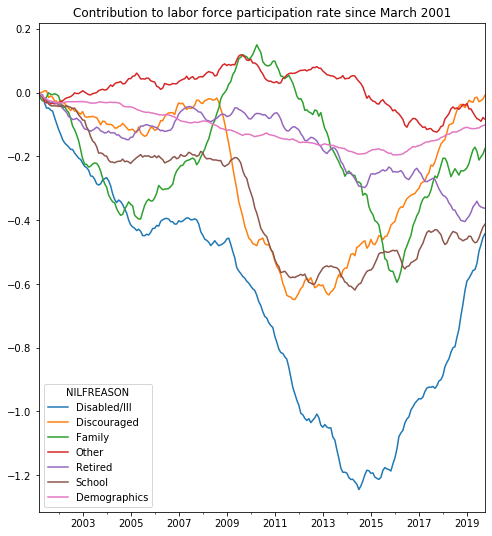

In [4]:
%matplotlib inline
title='Contribution to labor force participation rate since March 2001'
results.plot(figsize=(8, 9), title=title);